## COMP 551 Assignment 2 - Simon Arts, Talia Cooper & Rex Hamilton

Import Statements

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from re import X
import re
from collections import Counter
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer

np.random.seed(123)

# Data (ETF) - IMDB Data

In [ ]:
def import_data_imdb_train():
  """
  Import and Transform IMDB data to return a data matrix
  returns :  X, y, total features, important features
  """


  imdb_vocab = open("/content/imdb.vocab")
  imdb_BOW_train = open("/content/labeledBow_train.feat")

  features = np.array(imdb_vocab.read().split("\n"))
  reviews = np.array(imdb_BOW_train.read().split("\n"))

  reviews_score_split = np.zeros((len(reviews), 2), dtype=object);
  reviews = reviews[:len(reviews)-2]


  for entry in range(len(reviews)):

    before_space, after_space = reviews[entry].split(' ', 1)
    reviews_score_split[entry][0] = before_space
    reviews_score_split[entry][1] = after_space



  feature_frequencies = np.zeros(len(features), dtype=int)

  for entry in reviews_score_split:


    index_count = np.array(str(entry[1]).split(" "))


    for i in index_count:
      tup = np.array(i.split(":"))
      if len(tup) != 2:
        continue
      feature_frequencies[int(tup[0])] += 1



  important_features = []
  for i in range(len(feature_frequencies)):
    if (feature_frequencies[i]/len(reviews) > 0.01 and feature_frequencies[i]/len(reviews) < 0.5):
      important_features.append(i)



  x = np.zeros((len(reviews_score_split), len(important_features)), dtype=int);
  y = np.zeros(len(reviews_score_split), dtype=int)



  for score_BOW_index in range(len(reviews_score_split)):


    review = np.zeros(len(important_features), dtype=int)
    BOW = np.array(str(reviews_score_split[score_BOW_index][1]).split(" "))
    score = int(reviews_score_split[score_BOW_index][0])


    y[score_BOW_index] = score


    for index_count in BOW:

      index_count = np.array(index_count.split(":"))

      if len(index_count) != 2:
        continue

      word_index = int(index_count[0])
      word_freq = int(index_count[1])


      if (word_index in important_features):
        review[important_features.index(word_index)] = word_freq


    x[score_BOW_index] = review


  return (x, y, features, important_features)



In [ ]:
x_train, y_train, imdb_features, important_features = import_data_imdb_train()

print(x_train)
print(y_train)

print(x_train.shape)
print(y_train.shape)

print(f"X_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Number of features: {len(imdb_features)}")
print(f"Number of important features: {len(important_features)}")


[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[9 7 9 ... 2 0 0]
(25001, 1744)
(25001,)
X_train shape: (25001, 1744)
y_train shape: (25001,)
Number of features: 89527
Number of important features: 1744


In [ ]:

unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))


plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Class Distribution of Sentiment Scores in IMDB Reviews')
plt.xticks(np.arange(min(unique), max(unique)+1, 1.0))
plt.show()

In [ ]:
def import_data_imdb_test():
  imdb_BOW_test= open("/content/labeledBow_test.feat")

  reviews = np.array(imdb_BOW_test.read().split("\n"))

  reviews_score_split = np.zeros((len(reviews), 2), dtype=object);
  reviews = reviews[:len(reviews)-3]

  for entry in range(len(reviews)):

    before_space, after_space = reviews[entry].split(' ', 1)
    reviews_score_split[entry][0] = before_space
    reviews_score_split[entry][1] = after_space


  x = np.zeros((len(reviews_score_split), len(important_features)), dtype=int);
  y = np.zeros(len(reviews_score_split), dtype=int)


  for score_BOW_index in range(len(reviews_score_split)):


    review = np.zeros(len(important_features), dtype=int)
    BOW = np.array(str(reviews_score_split[score_BOW_index][1]).split(" "))
    score = int(reviews_score_split[score_BOW_index][0])


    y[score_BOW_index] = score


    for index_count in BOW:

      index_count = np.array(index_count.split(":"))

      if len(index_count) != 2:
        continue

      word_index = int(index_count[0])
      word_freq = int(index_count[1])


      if (word_index in important_features):
        review[important_features.index(word_index)] = word_freq


    x[score_BOW_index] = review

  return (x, y)


In [ ]:
x_test, y_test = import_data_imdb_test()

print(x_test)
print(y_test)

print(x_test.shape)
print(y_test.shape)

[[1 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [4 3 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[10 10  7 ...  0  0  0]
(25001, 1744)
(25001,)


#Linear Regression Class

In [ ]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])

        self.w = np.linalg.lstsq(x, y)[0]
        return self

    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

Extracting Top features using Linear Regression - IMDB


In [ ]:

model = LinearRegression()
model.fit(x_train, y_train)

coefficients = model.w[:-1] if model.add_bias else model.w

D = 100
top_features_indicesD1 = np.argsort(np.abs(coefficients))[-D:]


for word_index in top_features_indicesD1:
  word = imdb_features[important_features[word_index]]
  coef = coefficients[word_index]

  print(f"{word}: correlation coefficient = {coef}")




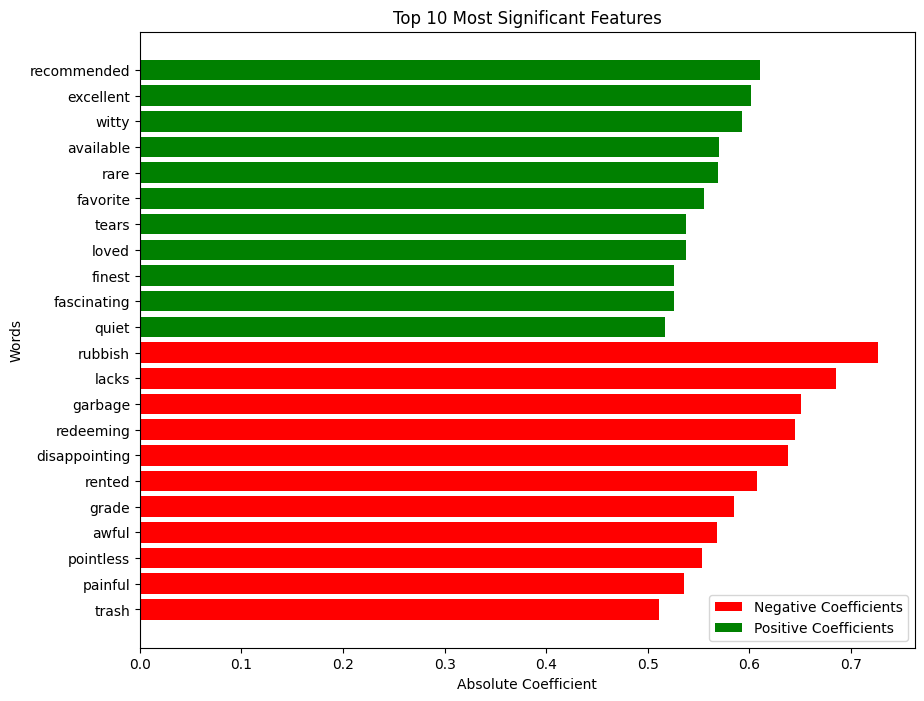

In [ ]:
from operator import ne


top_features_indicesD1 = np.argsort(np.abs(coefficients))[-30:]

positive_words = []
positive_coefficients = []
negative_words = []
negative_coefficients = []

for word_index in top_features_indicesD1:
    word = imdb_features[important_features[word_index]]
    coef = coefficients[word_index]
    if coef >= 0 and len(positive_words) <= 10:
        positive_words.append(word)
        positive_coefficients.append(coef)
    elif coef < 0 and len(negative_words) <= 10:
        negative_words.append(word)
        negative_coefficients.append(coef * -1)

fig, ax = plt.subplots(figsize=(10, 8))

ax.barh(negative_words, negative_coefficients, color='red', label='Negative Coefficients')


ax.barh(positive_words, positive_coefficients, color='green', label='Positive Coefficients')



ax.set_xlabel('Absolute Coefficient')
ax.set_ylabel('Words')
ax.set_title('Top 10 Most Significant Features')
ax.legend()

plt.show()


# Logistic Regression

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))

In [ ]:
class LogisticRegression:

  def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
    self.add_bias = add_bias
    self.learning_rate = learning_rate
    self.epsilon = epsilon
    self.max_iters = max_iters
    self.verbose = verbose
    self.loss_history = []

  def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))
    grad = np.dot(x.T, yh - y)/N
    return grad

  def compute_loss(self, x, y):
    yh = logistic(np.dot(x, self.w))
    loss = -np.mean(y * np.log(yh) + (1 - y) * np.log(1 - yh))
    return loss

  def fit(self, x, y):
    if x.ndim == 1:
      x = x[:, None]
    if self.add_bias:
      N = x.shape[0]
      x = np.column_stack([x,np.ones(N)])
    N,D = x.shape
    self.w = np.zeros(D)
    g = np.inf
    t = 0
    while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
      print(t)
      g = self.gradient(x, y)
      self.w = self.w - self.learning_rate * g
      loss = self.compute_loss(x, y)
      self.loss_history.append(loss)
      t += 1

    if self.verbose:
      print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
      print(f'the weight found: {self.w}')
    return self

  def predict(self, x):
    if x.ndim == 1:
      x = x[:, None]
    Nt = x.shape[0]
    if self.add_bias:
      x = np.column_stack([x,np.ones(Nt)])
    yh = logistic(np.dot(x ,self.w))
    return yh

Predict x_test with binary y data.

In [ ]:
def convert_to_binary(y):
  binary_labels = np.where(y > 5, 1, 0)
  return binary_labels

In [ ]:
y_train_binary = convert_to_binary(y_train)
y_test_binary = convert_to_binary(y_test)


N = 25001
x = np.linspace(-5,5, N)

model = LogisticRegression(verbose=True, add_bias=False, max_iters=100)
yh = model.fit(x_train, y_train_binary).predict(x_test)

y_pred = (yh > 0.5).astype(int)
print(yh)

acc_test = sum(y_pred==y_test_binary)/len(y_test_binary)
print(acc_test)
plt.plot(x, y_test_binary, '.', label='dataset')
plt.plot(x, y_pred, 'g', alpha=.5, label='predictions')
plt.xlabel('x')
plt.ylabel(r'$y$')
plt.legend()
plt.show()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76


#Convergence Plot

In [ ]:
model = LogisticRegression(verbose=True, add_bias=True, max_iters=1000, learning_rate=0.2)
model.fit(x_train, y_train_binary)

plt.plot(model.loss_history, label='Loss over iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Convergence Plot')
plt.legend()
plt.show()


TypeError: LogisticRegression.__init__() got an unexpected keyword argument 'add_bias'

###Top 10 Positive and Negative Features: Logistic Regression

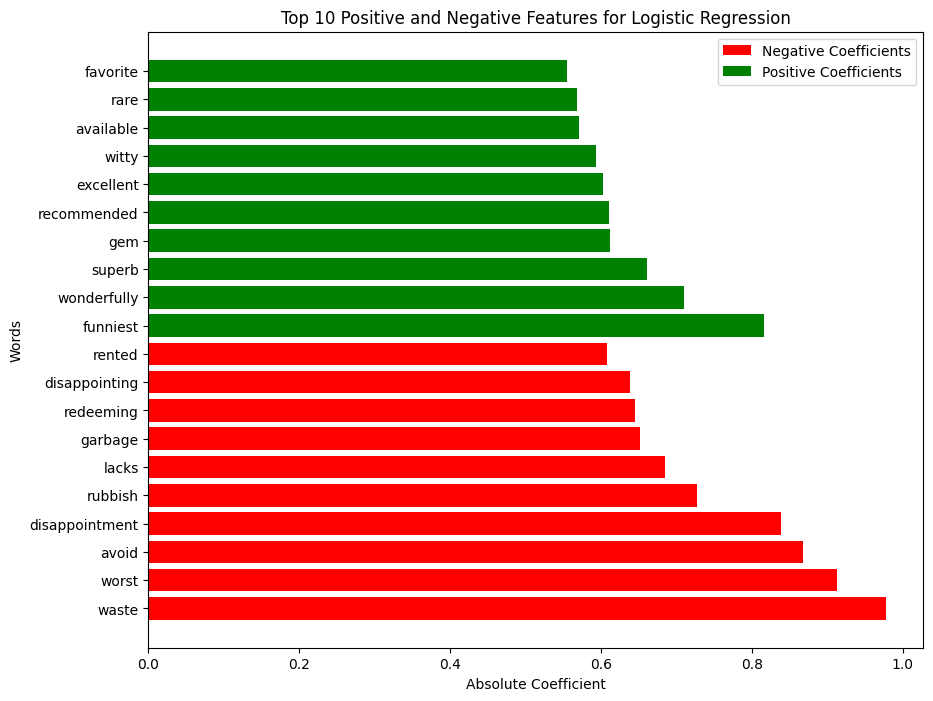

In [ ]:
feature_importance = [(imdb_features[important_features[i]], coefficients[i]) for i in top_features_indicesD1]
positive_features = [(word, coef) for word, coef in feature_importance if coef > 0]
negative_features = [(word, coef) for word, coef in feature_importance if coef < 0]

sorted_positive_features = sorted(positive_features, key=lambda x: x[1], reverse=True)
sorted_negative_features = sorted(negative_features, key=lambda x: x[1])

top_positive_words = [word for word, _ in sorted_positive_features[:10]]
top_positive_coefficients = [coef for _, coef in sorted_positive_features[:10]]
top_negative_words = [word for word, _ in sorted_negative_features[:10]]
top_negative_coefficients = [-coef for _, coef in sorted_negative_features[:10]]
fig, ax = plt.subplots(figsize=(10, 8))


ax.barh(top_negative_words, top_negative_coefficients, color='red', label='Negative Coefficients')
ax.barh(top_positive_words, top_positive_coefficients, color='green', label='Positive Coefficients')


ax.set_xlabel('Absolute Coefficient')
ax.set_ylabel('Words')
ax.set_title('Top 10 Positive and Negative Features for Logistic Regression')
ax.legend()

plt.show()


#ROC Curve Comparison

Decision Tree Accuracy: 0.7035
Logistic Regression Accuracy: 0.8236


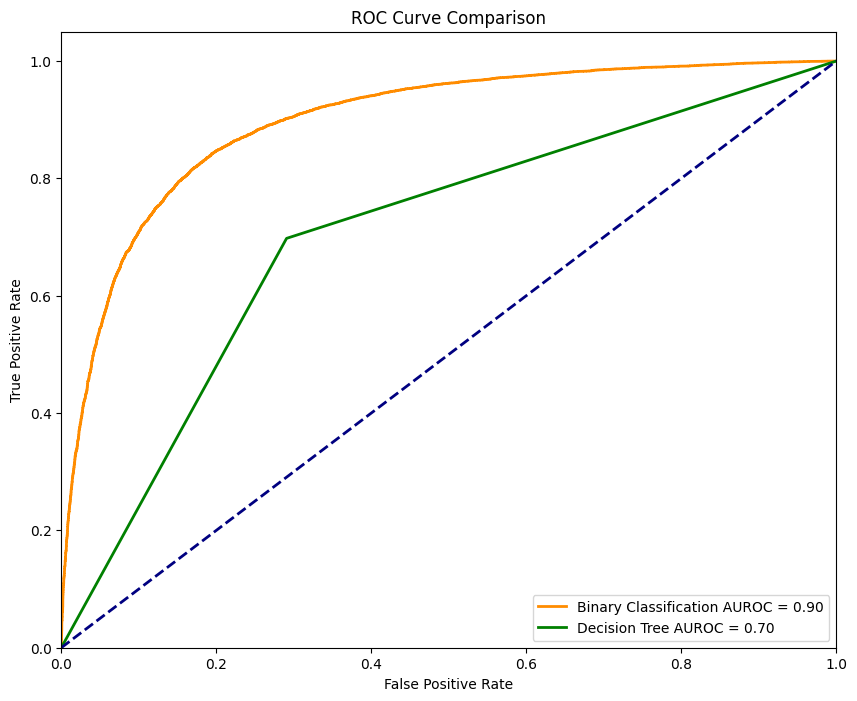

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

fpr_lr, tpr_lr, _ = roc_curve(y_test_binary, yh)
roc_auc_lr = auc(fpr_lr, tpr_lr)

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train, y_train_binary)
dt_probs = dt_model.predict_proba(x_test)[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_test_binary, dt_probs)
roc_auc_dt = auc(fpr_dt, tpr_dt)

dt_predictions = dt_model.predict(x_test)
accuracy_dt = accuracy_score(y_test_binary, dt_predictions)
print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")

y_pred_lr = (yh > 0.5).astype(int)
accuracy_lr = accuracy_score(y_test_binary, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")


plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'Binary Classification AUROC = {roc_auc_lr:.2f}')
plt.plot(fpr_dt, tpr_dt, color='green', lw=2, label=f'Decision Tree AUROC = {roc_auc_dt:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()


###AUROCs for Different % of Training Data

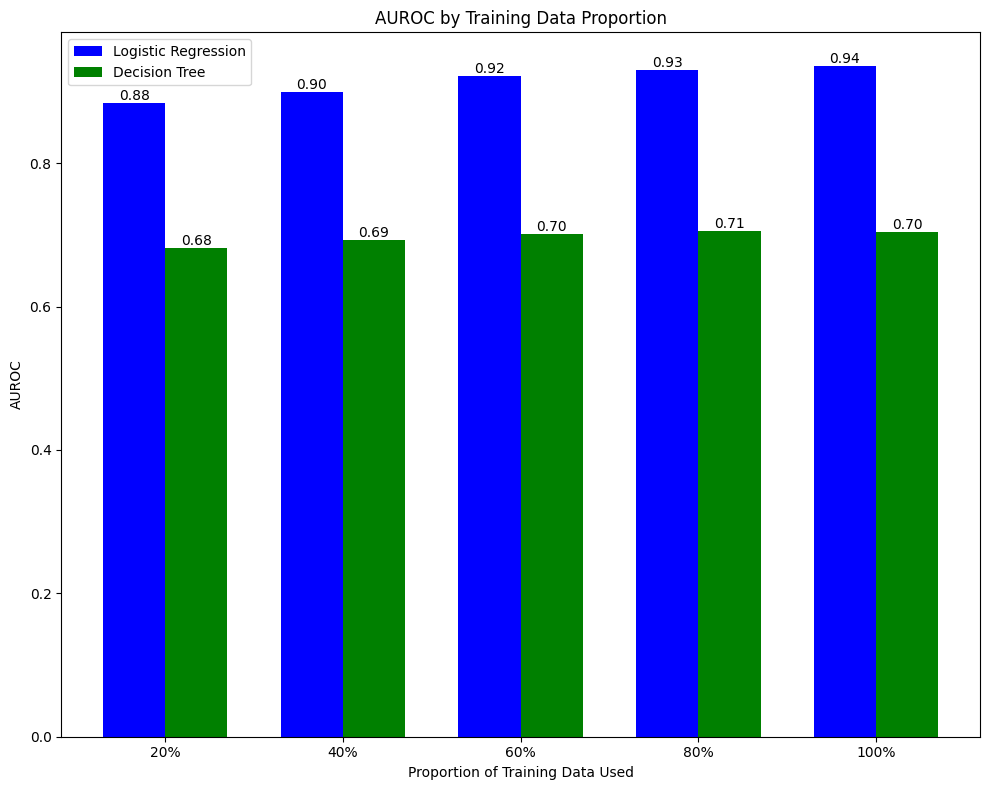

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score


auroc_lr = []
auroc_dt = []

train_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]

for size in train_sizes:
    if size < 1.0:
        X_train_sample, _, y_train_sample, _ = train_test_split(
            x_train, y_train_binary, train_size=size, random_state=42, stratify=y_train_binary
        )
    else:
        X_train_sample = x_train
        y_train_sample = y_train_binary

    lr_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

    lr_pipeline.fit(X_train_sample, y_train_sample)
    lr_pred_probs = lr_pipeline.predict_proba(x_test)[:, 1]
    auroc_lr.append(roc_auc_score(y_test_binary, lr_pred_probs))

    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train_sample, y_train_sample)
    dt_pred_probs = dt_model.predict_proba(x_test)[:, 1]
    auroc_dt.append(roc_auc_score(y_test_binary, dt_pred_probs))

plt.figure(figsize=(10, 8))
indices = np.arange(len(train_sizes))
bar_width = 0.35

lr_bars = plt.bar(indices - bar_width/2, auroc_lr, bar_width, label='Logistic Regression', color='blue')
dt_bars = plt.bar(indices + bar_width/2, auroc_dt, bar_width, label='Decision Tree', color='green')

for bar, score in zip(lr_bars, auroc_lr):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{score:.2f}', ha='center', va='bottom')

for bar, score in zip(dt_bars, auroc_dt):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{score:.2f}', ha='center', va='bottom')

plt.xlabel('Proportion of Training Data Used')
plt.ylabel('AUROC')
plt.title('AUROC by Training Data Proportion')
plt.xticks(indices, [f'{int(size * 100)}%' for size in train_sizes])
plt.legend()
plt.tight_layout()
plt.show()


#Data Set 2: News Articles

In [ ]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif


cats = ['sci.med', 'talk.politics.guns', 'rec.sport.hockey', 'sci.electronics', 'alt.atheism']
train_data = fetch_20newsgroups(subset="train", categories=cats, remove=['headers', 'footers', 'quotes'])
test_data = fetch_20newsgroups(subset="test", categories=cats, remove=['headers', 'footers', 'quotes'])

count_vector = CountVectorizer(stop_words='english', max_df=0.5, min_df=0.01)
X_train_num = count_vector.fit_transform(train_data.data)
X_test_num = count_vector.transform(test_data.data)

mutual_info = mutual_info_classif(X_train_num, train_data.target, discrete_features=True)
word_indices = np.argsort(mutual_info)[::-1]
feature_names = np.array(count_vector.get_feature_names_out())[word_indices]

best_features = feature_names[word_indices[:150]]
best_feature_indices = [count_vector.vocabulary_.get(feature) for feature in best_features]
X_train = X_train_num[:, best_feature_indices]
X_test = X_test_num[:, best_feature_indices]

y_train = []
for i in range(len(train_data.target)):
  if train_data.target[i] == 0:
      y_train.append([1, 0, 0, 0, 0])
  elif train_data.target[i] == 1:
      y_train.append([0, 1, 0, 0, 0])
  elif train_data.target[i] == 2:
      y_train.append([0, 0, 1, 0, 0])
  elif train_data.target[i] == 3:
      y_train.append([0, 0, 0, 1, 0])
  elif train_data.target[i] == 4:
      y_train.append([0, 0, 0, 0, 1])


y_test = []
for i in range(len(test_data.target)):
  if test_data.target[i] == 0:
      y_test.append([1, 0, 0, 0, 0])
  elif test_data.target[i] == 1:
      y_test.append([0, 1, 0, 0, 0])
  elif test_data.target[i] == 2:
      y_test.append([0, 0, 1, 0, 0])
  elif test_data.target[i] == 3:
      y_test.append([0, 0, 0, 1, 0])
  elif test_data.target[i] == 4:
      y_test.append([0, 0, 0, 0, 1])


#Multiclass Logistic Regression Implementation

In [ ]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    def get_coefficients(self):
        return self.W

    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                #print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                #print(f"iter {i}: {loss_train:.3f}")
                pass
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X_train.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()
        return diff.sum()


#Fitting the Second Dataset to the Multiclass Model

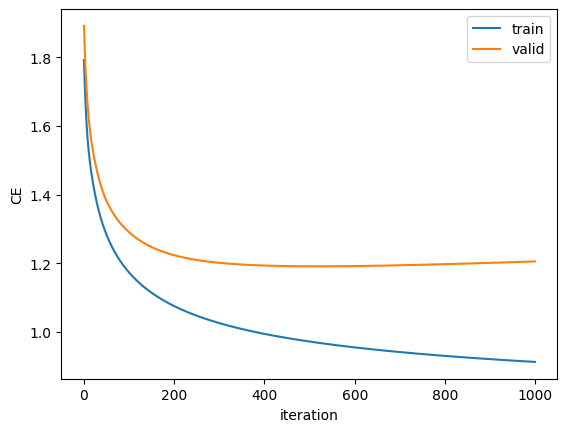

Training Accuracy: 0.61067615658363
Validation Accuracy: 0.5049786628733998
Testing Accuracy: 0.4665954035275254


<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
from sklearn import model_selection
import matplotlib.pyplot as plt

y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, test_size = 0.5, random_state=1, shuffle=True)

N, C = y_train.shape

D = X_train.shape[1]

mlr = Multinomial_logistic(D, C)

ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid,lr= 0.0005, niter=1000)

plt.clf()
plt.plot(ce_train/X_train.shape[0], label='train')
plt.plot(ce_valid/X_valid.shape[0], label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)

def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

train_accuracy = evaluate(mlr.predict(X_train), y_train)
valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy = evaluate(mlr.predict(X_test), y_test)

print("Training Accuracy: "+str(train_accuracy))
print("Validation Accuracy: "+str(valid_accuracy))
print("Testing Accuracy: "+str(test_accuracy))

Checking Gradient Difference:

In [ ]:
grad_difference = mlr.check_grad(X_train, y_train)
print("Gradient Difference: "+str(grad_difference))

Gradient Difference: 2.999608396837805e-06


#Heatmap

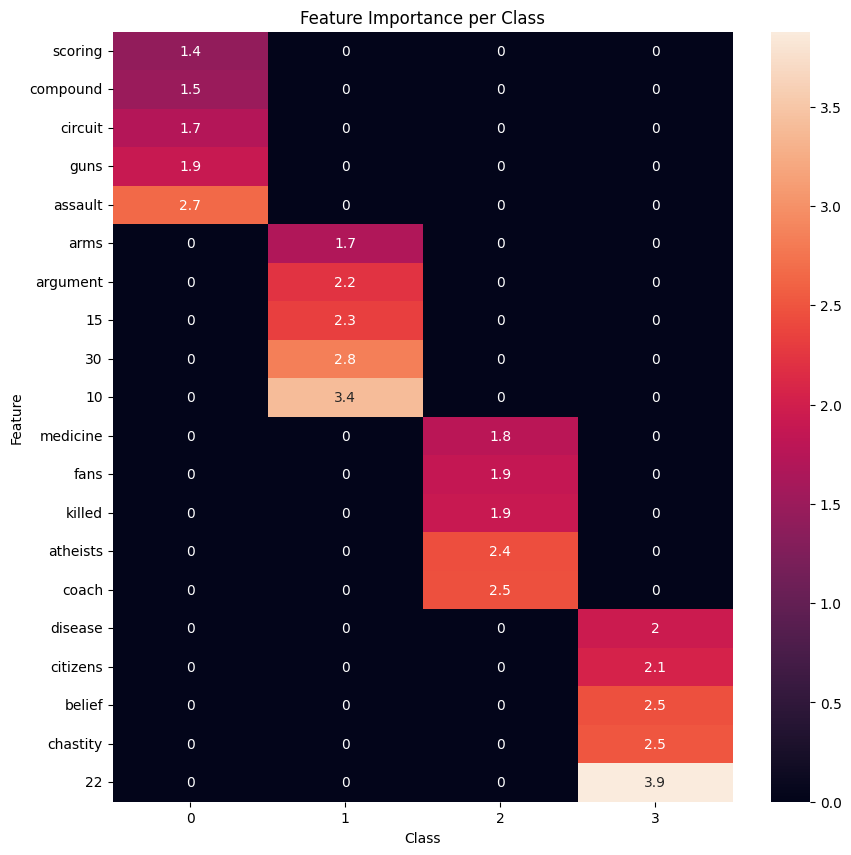

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
coefficients = mlr.get_coefficients().T
best_indices = np.argsort(coefficients, axis=1)[:,-5:]
plot_array = np.zeros((20,4))

y_labels = []
for i in range(4):
    class_feature_names = [feature_names[index] for index in best_indices[i]]
    y_labels.extend(class_feature_names)
    for j in range(5):
        plot_array[j + (i * 5), i] = coefficients[i, best_indices[i, j]]

y_labels = y_labels[:20]
x_labels = [0,1,2,3]
plt.figure(figsize=(10, 10))
sns.heatmap(plot_array, annot=True, xticklabels= x_labels, yticklabels= y_labels)
plt.title("Feature Importance per Class")
plt.xlabel("Class")
plt.ylabel("Feature")
plt.show()

#Decision Tree for News Articles using Sklearn

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.3180117584179583


#Testing Classification Accuracy on Different Amounts of Data

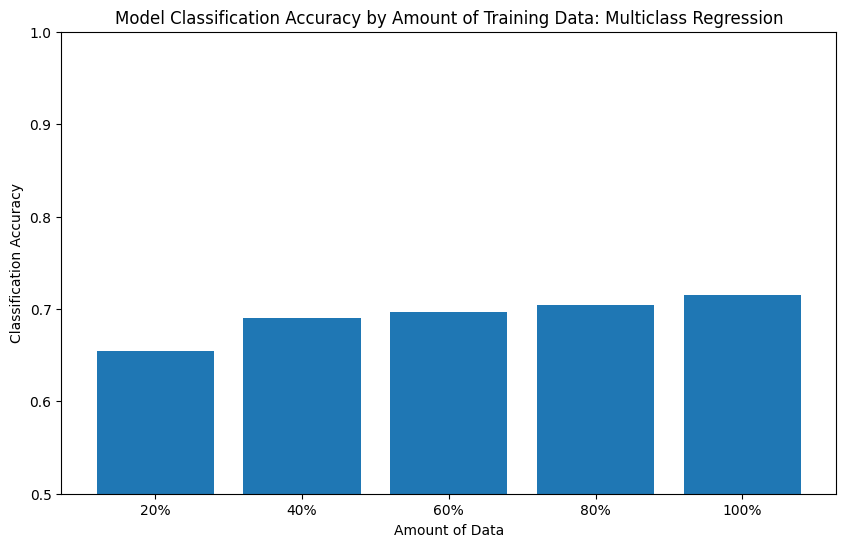

In [ ]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, test_size = 0.5, random_state=1, shuffle=True)

N, C = y_train.shape
D = X_train.shape[1]
mlr = Multinomial_logistic(D, C)


accuracies = []
threshold = 0.0
for i in range(5):
  X_train_exp, X_valid_exp, y_train_exp, y_valid_exp = model_selection.train_test_split(
    X_train, y_train, test_size = threshold+0.2, random_state=1, shuffle=True)
  ce_train, ce_valid = mlr.fit(X_train_exp, y_train_exp, X_valid_exp, y_valid_exp,lr= 0.0005, niter=1000)
  accuracies.append(evaluate(mlr.predict(X_train_exp), y_train_exp))


plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), accuracies, tick_label=[f"{20 * i}%" for i in range(1, 6)])
plt.xlabel('Amount of Data')
plt.ylabel('Classification Accuracy')
plt.ylim(0.5, 1)
plt.title('Model Classification Accuracy by Amount of Training Data: Multiclass Regression')
plt.show()

Decision Tree:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize

clf = DecisionTreeClassifier()
accuracies = []
threshold = 0.0
for i in range(5):
  X_train_exp, X_valid_exp, y_train_exp, y_valid_exp = model_selection.train_test_split(
    X_train, y_train, test_size = threshold+0.2, random_state=1, shuffle=True)
  clf.fit(X_train_exp, y_train_exp)
  y_pred = clf.predict(X_valid_exp)
  accuracies.append(accuracy_score(y_valid_exp, y_pred))
print(accuracies)
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), accuracies, tick_label=[f"{20 * i}%" for i in range(1, 6)])
plt.xlabel('Amount of Data')
plt.ylabel('Classification Accuracy')
plt.ylim(0, 0.5)
plt.title('Model Classification Accuracy by Amount of Training Data: Decision Tree')
plt.show()